In [1]:
# !pip install seaborn

In [2]:
from dotenv import load_dotenv
load_dotenv()

True

In [3]:
import os
from functools import partial
from pathlib import Path

import pandas as pd
from openai import OpenAI

from bellek.utils import jprint
from bellek.utils import set_seed

set_seed(42)

In [4]:
from tqdm.auto import tqdm
tqdm.pandas()

## Dataset

In [5]:
from bellek.musique.constants import ABLATION_RECORD_IDS

df = pd.read_json('../../data/generated/musique-evaluation/dataset.jsonl', orient='records', lines=True)
df = df.set_index('id', drop=False).loc[ABLATION_RECORD_IDS].copy().reset_index(drop=True)
qd_df = pd.read_json('../../data/generated/musique-evaluation/question-decomposition.jsonl', orient='records', lines=True)
df = pd.merge(df.drop(columns=['question', 'question_decomposition']), qd_df, on='id', suffixes=('', ''))
# df = df.head()
print(df.shape)
df.head()

(100, 8)


,id,paragraphs,answer,answer_aliases,answerable,answers,question,question_decomposition
0,2hop__575188_342798,"[{'idx': 0, 'title': 'Liliana Mumy', 'paragrap...",Ahmad Shah Qajar,[Ahmad Shah Qajar],True,[Ahmad Shah Qajar],Who is the child of Mahmoud Mirza's father?,"[{'id': 575188, 'question': 'Who is Mahmoud Mi..."
1,2hop__731584_700117,"[{'idx': 0, 'title': 'KAPE', 'paragraph_text':...",Berrien County,[Berrien County],True,[Berrien County],In which county is the city to which KKVU is l...,"[{'id': 731584, 'question': 'To which city is ..."
2,2hop__690412_526810,"[{'idx': 0, 'title': 'Cabramatta Creek', 'para...",Chao Phraya River,[Chao Phraya River],True,[Chao Phraya River],For what river does the river on which Pa Sak ...,"[{'id': 690412, 'question': 'On which river is..."
3,2hop__263638_69048,"[{'idx': 0, 'title': 'Michael J. Barron', 'par...",Honorable Justice Abiodun Smith,[Honorable Justice Abiodun Smith],True,[Honorable Justice Abiodun Smith],Who is the Chief Judge of the Tebesa Nemine's ...,"[{'id': 263638, 'question': 'Where was Tebesa ..."
4,2hop__142842_68489,"[{'idx': 0, 'title': 'Perfect Night: Live in L...",Snapper Foster,[Snapper Foster],True,[Snapper Foster],Who did the performer of Night Rocker play on ...,"[{'id': 142842, 'question': 'Who performed Nig..."


In [6]:
jerx_file = Path("../../data/raw/musique-evaluation/jerx-inferences/llama3-base.jsonl")
jerx_df = pd.read_json(jerx_file, lines=True)
print(len(jerx_df))
jerx_df.head()

25038


,id,paragraph_idx,paragraph_text,paragraph_title,is_supporting,text,input,generation
0,2hop__131818_161450,0,Maria Carrillo High School is a public high sc...,Maria Carrillo High School,False,# Maria Carrillo High School\nMaria Carrillo H...,[{'content': 'You are an excellent knowledge g...,Maria Carrillo High School | location | Santa ...
1,2hop__131818_161450,1,"Golestān Province (Persian: استان گلستان‎, Ost...",Golestan Province,True,# Golestan Province\nGolestān Province (Persia...,[{'content': 'You are an excellent knowledge g...,Golestan Province | location | north-east of I...
2,2hop__131818_161450,2,Voshmgir District () is a district (bakhsh) in...,Voshmgir District,True,# Voshmgir District\nVoshmgir District () is a...,[{'content': 'You are an excellent knowledge g...,"Voshmgir District | location | Aqqala County, ..."
3,2hop__131818_161450,3,52 Heroor is a village in the southern state o...,52 Heroor,False,# 52 Heroor\n52 Heroor is a village in the sou...,[{'content': 'You are an excellent knowledge g...,"52 Heroor | location | Karnataka, India\n52 He..."
4,2hop__131818_161450,4,Vennaimalai is a village of Karur District loc...,Vennaimalai,False,# Vennaimalai\nVennaimalai is a village of Kar...,[{'content': 'You are an excellent knowledge g...,Vennaimalai | location | Karur District\nVenna...


In [7]:
row = df.iloc[0]
row['question_decomposition']

[{'id': 575188,
  'question': "Who is Mahmoud Mirza's father?",
  'answer': 'Mohammad Ali Shah Qajar',
  'paragraph_support_idx': 8},
 {'id': 342798,
  'question': 'Who is the child of #1?',
  'answer': 'Ahmad Shah Qajar',
  'paragraph_support_idx': 7}]

In [8]:
jerx_mapping = {(row['id'], row['paragraph_idx']): row['generation'] for _, row in jerx_df.iterrows()}

def extract_triplets(example: dict):
    example["triplets_str"] = [jerx_mapping[(example['id'], p['idx'])].strip() for p in example['paragraphs']]
    return example

In [9]:
df = df.apply(extract_triplets, axis=1)
df.head()

,id,paragraphs,answer,answer_aliases,answerable,answers,question,question_decomposition,triplets_str
0,2hop__575188_342798,"[{'idx': 0, 'title': 'Liliana Mumy', 'paragrap...",Ahmad Shah Qajar,[Ahmad Shah Qajar],True,[Ahmad Shah Qajar],Who is the child of Mahmoud Mirza's father?,"[{'id': 575188, 'question': 'Who is Mahmoud Mi...",[Liliana Mumy | father | Bill Mumy\nBill Mumy ...
1,2hop__731584_700117,"[{'idx': 0, 'title': 'KAPE', 'paragraph_text':...",Berrien County,[Berrien County],True,[Berrien County],In which county is the city to which KKVU is l...,"[{'id': 731584, 'question': 'To which city is ...",[KAPE | broadcast frequency | 1550 AM\nKAPE | ...
2,2hop__690412_526810,"[{'idx': 0, 'title': 'Cabramatta Creek', 'para...",Chao Phraya River,[Chao Phraya River],True,[Chao Phraya River],For what river does the river on which Pa Sak ...,"[{'id': 690412, 'question': 'On which river is...",[Cabramatta Creek | location | Sydney\nCabrama...
3,2hop__263638_69048,"[{'idx': 0, 'title': 'Michael J. Barron', 'par...",Honorable Justice Abiodun Smith,[Honorable Justice Abiodun Smith],True,[Honorable Justice Abiodun Smith],Who is the Chief Judge of the Tebesa Nemine's ...,"[{'id': 263638, 'question': 'Where was Tebesa ...",[Michael J. Barron | birth year | 1933\nMichae...
4,2hop__142842_68489,"[{'idx': 0, 'title': 'Perfect Night: Live in L...",Snapper Foster,[Snapper Foster],True,[Snapper Foster],Who did the performer of Night Rocker play on ...,"[{'id': 142842, 'question': 'Who performed Nig...",[Perfect Night: Live in London | recorded by |...


## Search

In [10]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer("all-MiniLM-L6-v2")

def search_semantic(docs: list[dict], query: str, top_k: int = 3):
    embeddings = model.encode([doc['text'] for doc in docs])
    query_vectors = model.encode([query])
    similarities = model.similarity(embeddings, query_vectors)
    sorted_indices = similarities.argsort(dim=0, descending=True)
    return [docs[i] for i in sorted_indices[:top_k]]

/home/pc/anaconda3/envs/baris/lib/python3.10/site-packages/torch/cuda/__init__.py:619: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/pc/anaconda3/envs/baris/lib/python3.10/site-packages/bitsandbytes/cextension.py:34: UserWarning: The installed version of bitsandbytes was compiled without GPU support. 8-bit optimizers, 8-bit multiplication, and GPU quantization are unavailable.
  warn("The installed version of bitsandbytes was compiled without GPU support. "


/home/pc/anaconda3/envs/baris/lib/python3.10/site-packages/bitsandbytes/libbitsandbytes_cpu.so: undefined symbol: cadam32bit_grad_fp32


/home/pc/anaconda3/envs/baris/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [11]:
import bm25s

def search_bm25(docs: list[dict], query: str, top_k: int = 3):
    top_k = min(top_k, len(docs))
    retriever = bm25s.BM25(corpus=docs)
    tokenized_corpus = bm25s.tokenize([doc['text'] for doc in docs])
    retriever.index(tokenized_corpus)
    results, _ = retriever.retrieve(bm25s.tokenize(query), k=top_k)
    return results[0].tolist()

In [12]:
def make_retriever(search_fn):
    def retrieval(row):
        docs = [{'text': p['paragraph_text'], **p} for p in row['paragraphs']]
        query1 = row['question_decomposition'][0]['question']
        query2 = row['question_decomposition'][1]['question'].replace("#1", row['question_decomposition'][0]['answer'])
        for i, qd, query  in zip(range(1,3), row['question_decomposition'], [query1, query2]):
            results = search_fn(docs, query, top_k = len(row['paragraphs']))
            retrieved_docs_ids = [result['idx'] for result in results]
            row[f'target_doc_idx_{i}'] = qd['paragraph_support_idx']
            row[f'retrieved_doc_ids_{i}'] = retrieved_docs_ids
            row[f'target_retrieval_pos_{i}'] = retrieved_docs_ids.index(qd['paragraph_support_idx']) + 1
        return row
    return retrieval

In [13]:
%%capture
df_bm25 = df.copy().progress_apply(make_retriever(search_bm25), axis=1)
df_bm25['algo'] = 'bm25'

In [14]:
df_semantic = df.copy().progress_apply(make_retriever(search_semantic), axis=1)
df_semantic['algo'] = 'semantic'

  0%|          | 0/100 [00:00<?, ?it/s]

## Visualize

In [ ]:
pd.options.display.float_format = '{:,.3f}'.format

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_perf(dataf):
    # Setting the plot style
    sns.set(style="whitegrid")

    # Plotting the distribution of retrieval positions for both sub-questions
    fig = plt.figure(figsize=(4, 3), dpi=400)
    sns.histplot(data=dataf, x='target_retrieval_pos_1', bins=20, color='blue', label='Sub-question 1', kde=False)
    sns.histplot(data=dataf, x='target_retrieval_pos_2', bins=20, color='red', label='Sub-question 2', kde=False)

    # Adding labels and title
    plt.xlabel('Position of Correct Answer')
    plt.ylabel('Frequency')
    plt.title('Performance of Semantic Retrieval Algorithm')
    plt.legend(title='Sub-questions')

    # Show the plot
    plt.tight_layout()
    plt.show()
    return fig

In [ ]:
def report_perf(dataf):
    # Define the list of top_k values
    top_k_values = [3, 5, 10]

    # Calculate hit rates for each top_k for both sub-questions
    for top_k in top_k_values:
        dataf[f'retrieval_success_1@{top_k}'] = dataf['target_retrieval_pos_1'].apply(lambda x: int(x < top_k))
        dataf[f'retrieval_success_2@{top_k}'] = dataf['target_retrieval_pos_2'].apply(lambda x: int(x < top_k))
        dataf[f'retrieval_success@{top_k}'] = dataf[f'retrieval_success_1@{top_k}'] & dataf[f'retrieval_success_2@{top_k}']

    # Initialize a list to hold the result
    hit_rate_results = []

    # Calculate hit rate for each top_k and append to results
    for top_k in top_k_values:
        hit_rate_1 = dataf[f'retrieval_success_1@{top_k}'].mean()
        hit_rate_2 = dataf[f'retrieval_success_2@{top_k}'].mean()
        retrieval_success = dataf[f'retrieval_success@{top_k}'].mean()
        hit_rate_results.append({
            'Top K': top_k,
            'Success Sub-question 1': hit_rate_1,
            'Success Sub-question 2': hit_rate_2,
            'Success': retrieval_success
        })
    # Create a result DataFrame from the results list
    return pd.DataFrame(hit_rate_results)

In [ ]:
report_perf(df_bm25)

,Top K,Success Sub-question 1,Success Sub-question 2,Success
0,3,0.810,0.850,0.690
1,5,0.910,0.960,0.870
2,10,0.970,0.970,0.940


In [ ]:
report_perf(df_semantic)

,Top K,Success Sub-question 1,Success Sub-question 2,Success
0,3,0.910,0.890,0.810
1,5,0.950,0.940,0.890
2,10,0.970,0.960,0.930


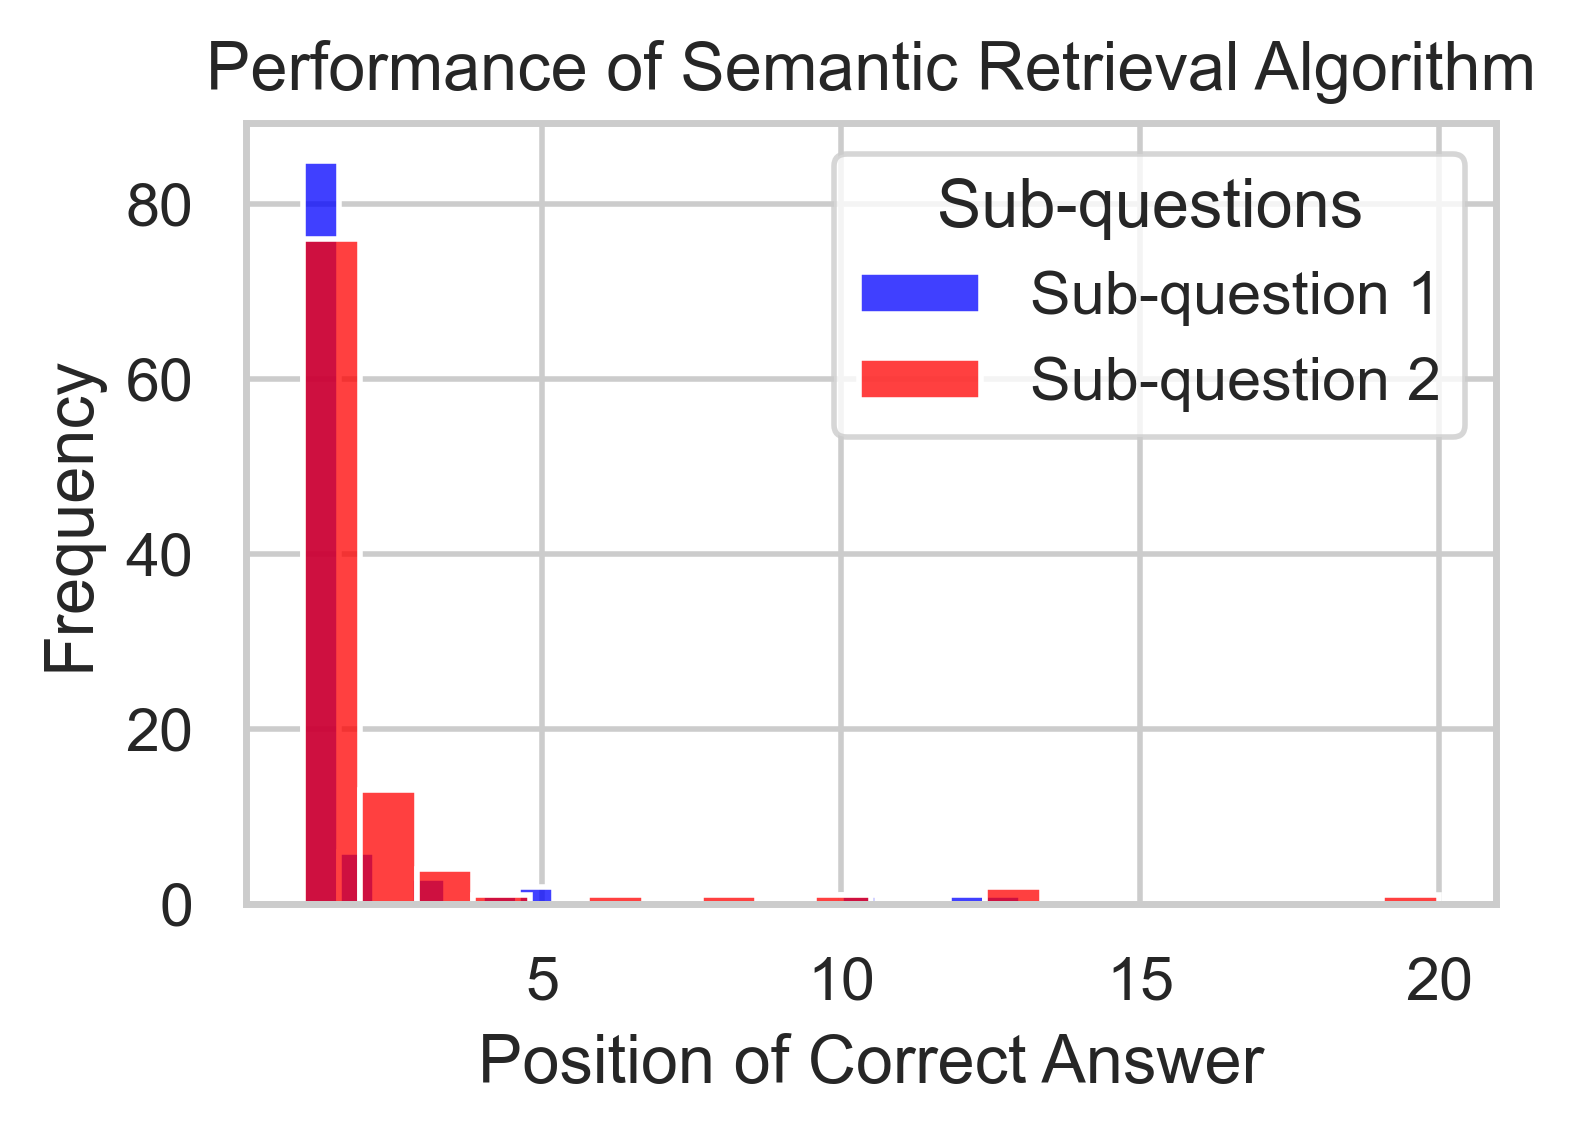

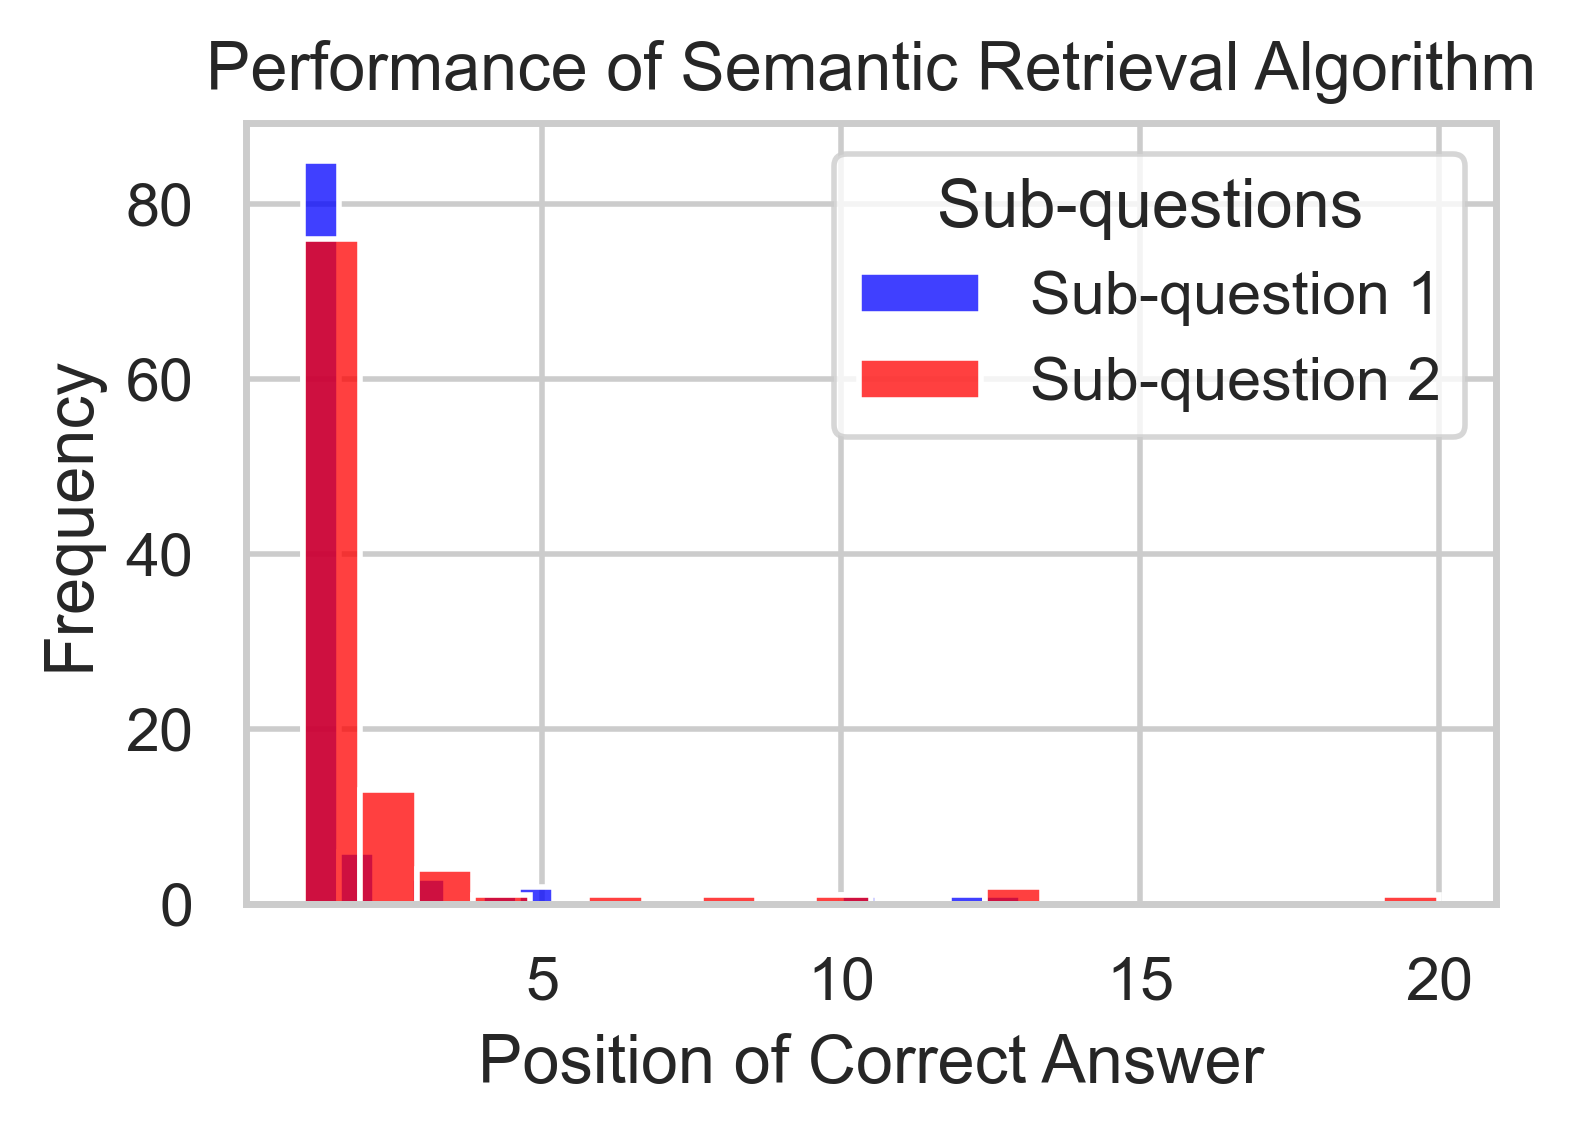

In [ ]:
plot_perf(df_semantic)